<a href="https://colab.research.google.com/github/jimenasalinas/RedditGoesGreen/blob/main/models/Topic_Modeling_Subreddit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Topic Modeling - By Subreddit

By Shwetha Srinivasan

In [ ]:
!pip install --upgrade pandas

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.corpus import stopwords

import gensim
from gensim import corpora
from nltk.tokenize import word_tokenize
import regex as re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import spacy


In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install pyLDAvis
import pyLDAvis.gensim

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
!python -m spacy download en_core_web_md

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path_gdrive = '/content/drive/Shareddrives/adv-ml-project/Data'

In [6]:
df_category = pd.read_csv(path_gdrive + '/' + 'by_category/comments_filtered.csv')

In [20]:
df_category.head()

,subreddit.name,date,body,sentiment,label
0,futurology,2022-08-31 23:53:39,Blaming environmentalists for the failure of n...,0.3094,1.0
1,canada,2022-08-31 23:27:11,"['Pipelines will be blown up,' says David Suzu...",-0.9719,0.0
2,australia,2022-08-31 23:19:53,\n&gt;You don't want there to be any actual ac...,-0.8434,0.0
3,collapse,2022-08-31 23:17:48,&gt; Sounds like we have 20 years\n\nWhy lie a...,-0.6249,0.0
4,canada,2022-08-31 23:14:46,I'm not running from anything.\n\nI haven't ex...,0.7942,1.0


In [7]:
df_category.shape

(307041, 5)

In [8]:
df_category['subreddit.name'].unique()

array(['futurology', 'canada', 'australia', 'collapse', 'the_donald'],
      dtype=object)

In [23]:
df_canada = df_category[df_category['subreddit.name'] == 'canada']
df_canada.shape

(59037, 5)

In [24]:
df_canada.columns

Index(['subreddit.name', 'date', 'body', 'sentiment', 'label'], dtype='object')

In [26]:
df_canada_sample.columns

Index(['subreddit.name', 'date', 'body', 'sentiment', 'label'], dtype='object')

In [11]:
df_australia = df_category[df_category['subreddit.name'] == 'australia']
df_australia.shape

(46267, 5)

In [13]:
df_futurology = df_category[df_category['subreddit.name'] == 'futurology']
df_futurology.shape

(83235, 5)

In [14]:
df_collapse = df_category[df_category['subreddit.name'] == 'collapse']
df_collapse.shape

(88010, 5)

In [15]:
df_donald = df_category[df_category['subreddit.name'] == 'the_donald']
df_donald.shape

(30492, 5)

In [37]:
def analyze_topics_over_time(df, text_column, date_column, num_topics=10, passes=15, topn_words=5):
    # Tokenize and preprocess the documents
    df = df.sample(frac=0.05, random_state=42)
    stop_words = set(stopwords.words('english'))
    tokenized_documents = [word_tokenize(doc.lower()) for doc in df[text_column].tolist()]
    filtered_documents = [
        [word for word in doc if word.isalnum() and word not in stop_words and not re.match(r'https?://\S+|www\.\S+|http\S+', word)]
        for doc in tokenized_documents
    ]

    # Create a dictionary and corpus
    dictionary = corpora.Dictionary(filtered_documents)
    corpus = [dictionary.doc2bow(doc) for doc in filtered_documents]

    # Build the LDA model
    lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, random_state=42)

    # Find dominant topics and their top words
    dominant_topics = []
    for doc_bow in corpus:
        doc_topics = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
        dominant_topic = sorted(doc_topics, key=lambda x: x[1], reverse=True)[0][0]
        top_words = [word for word, prob in lda_model.show_topic(dominant_topic, topn=topn_words)]
        top_words_str = ", ".join(top_words)
        topic_and_words = f"Topic {dominant_topic}: {top_words_str}"
        dominant_topics.append(topic_and_words)

    df['dominant_topic'] = dominant_topics
    df[date_column] = pd.to_datetime(df[date_column])
    df.set_index(date_column, inplace=True)

    # Resample and plot
    topic_counts_by_year = df.groupby([pd.Grouper(freq='Y'), 'dominant_topic']).size().unstack(fill_value=0)
    sns.set_theme(style="whitegrid")
    palette = sns.color_palette("husl", len(topic_counts_by_year.columns))

    plt.figure(figsize=(14, 7))
    for idx, topic in enumerate(topic_counts_by_year.columns):
        plt.plot(topic_counts_by_year.index.year, topic_counts_by_year[topic], marker='o', linewidth=2, markersize=8, label=f'{topic}', color=palette[idx])

    plt.title('Dominant Topics Over Time', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Frequency of Dominant Topic', fontsize=14)
    plt.legend(title='Dominant Topic', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    plt.xticks(topic_counts_by_year.index.year[::2], rotation=45)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

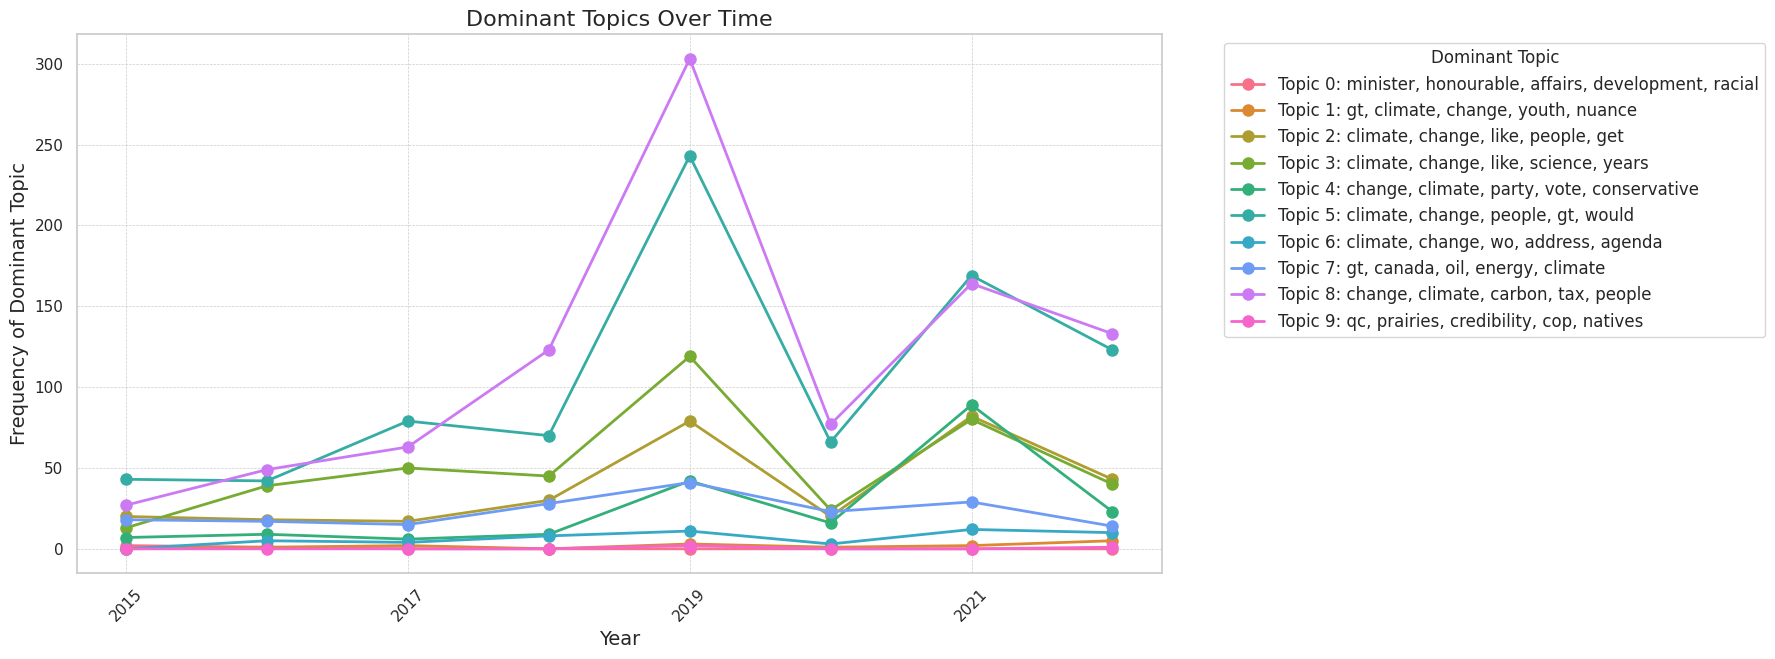

In [38]:
analyze_topics_over_time(df_canada, 'body', 'date', num_topics=10, passes=15, topn_words=5)

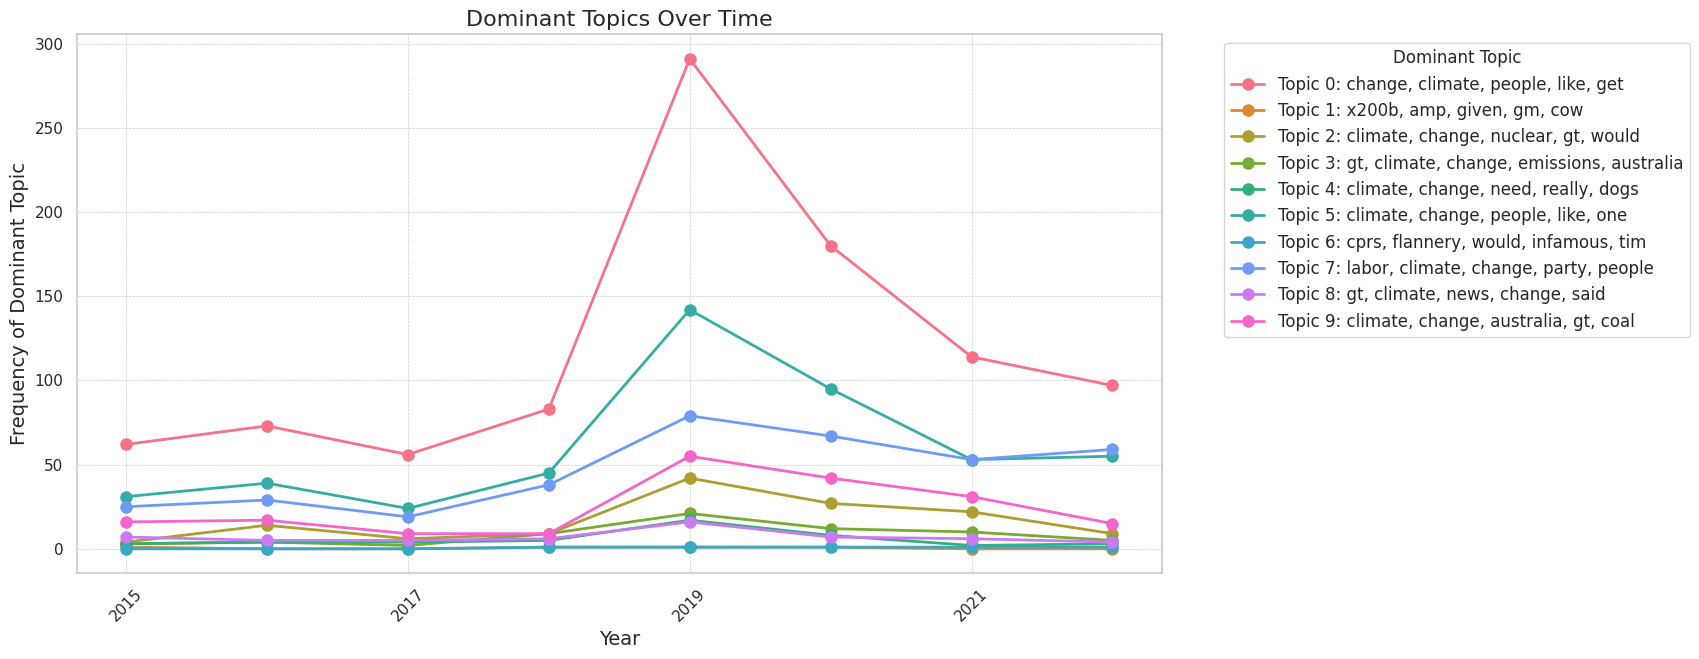

In [39]:
analyze_topics_over_time(df_australia, 'body', 'date', num_topics=10, passes=15, topn_words=5)

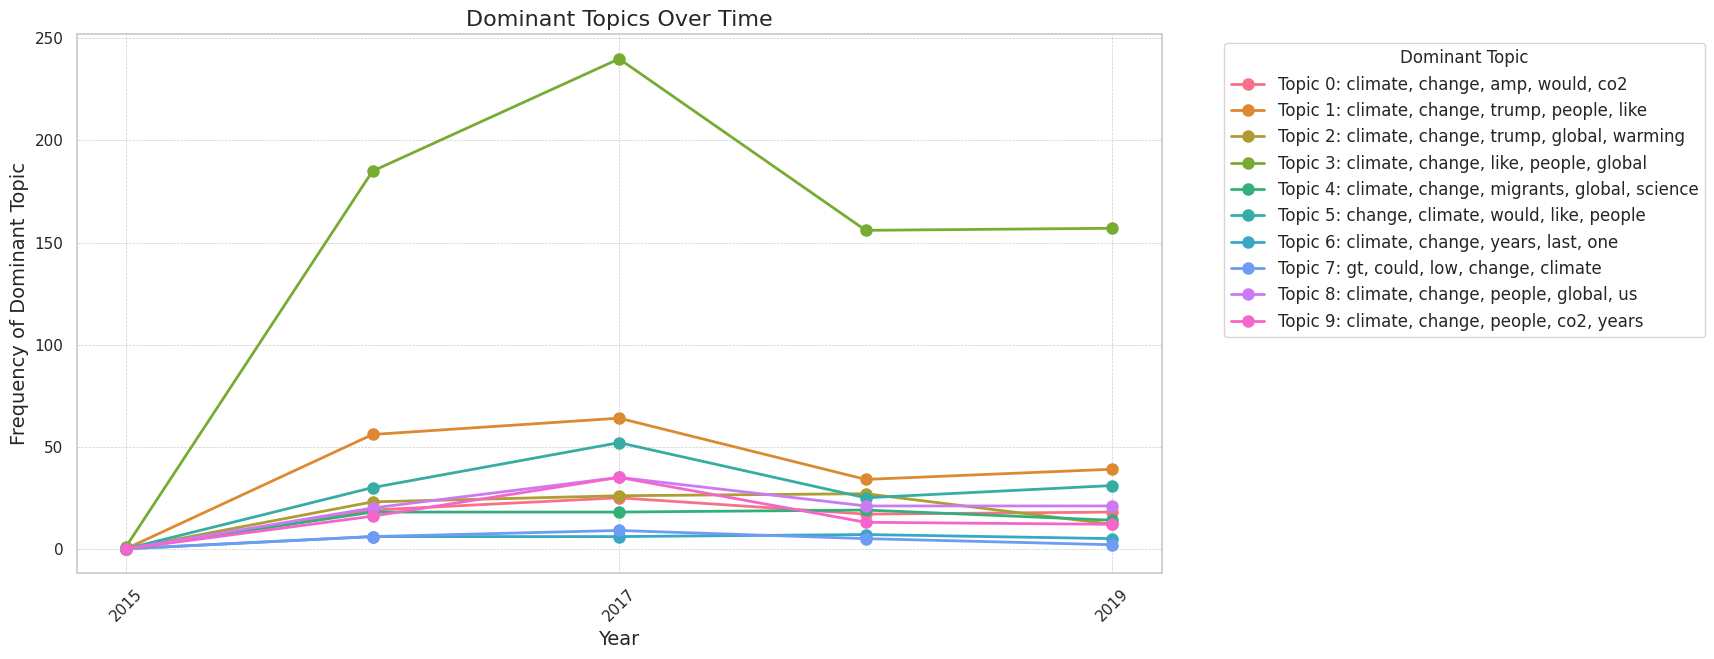

In [40]:
analyze_topics_over_time(df_donald, 'body', 'date', num_topics=10, passes=15, topn_words=5)

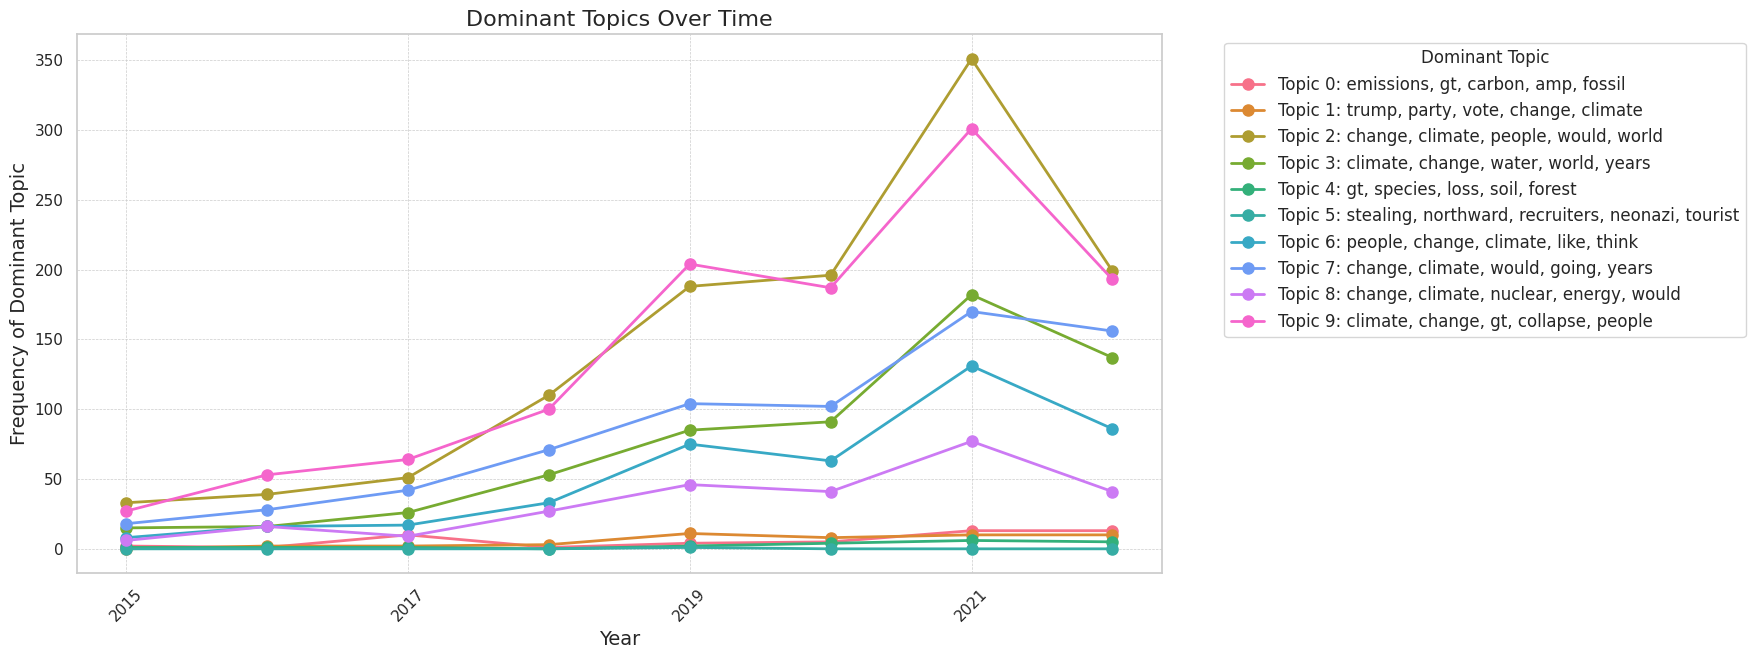

In [41]:
analyze_topics_over_time(df_collapse, 'body', 'date', num_topics=10, passes=15, topn_words=5)

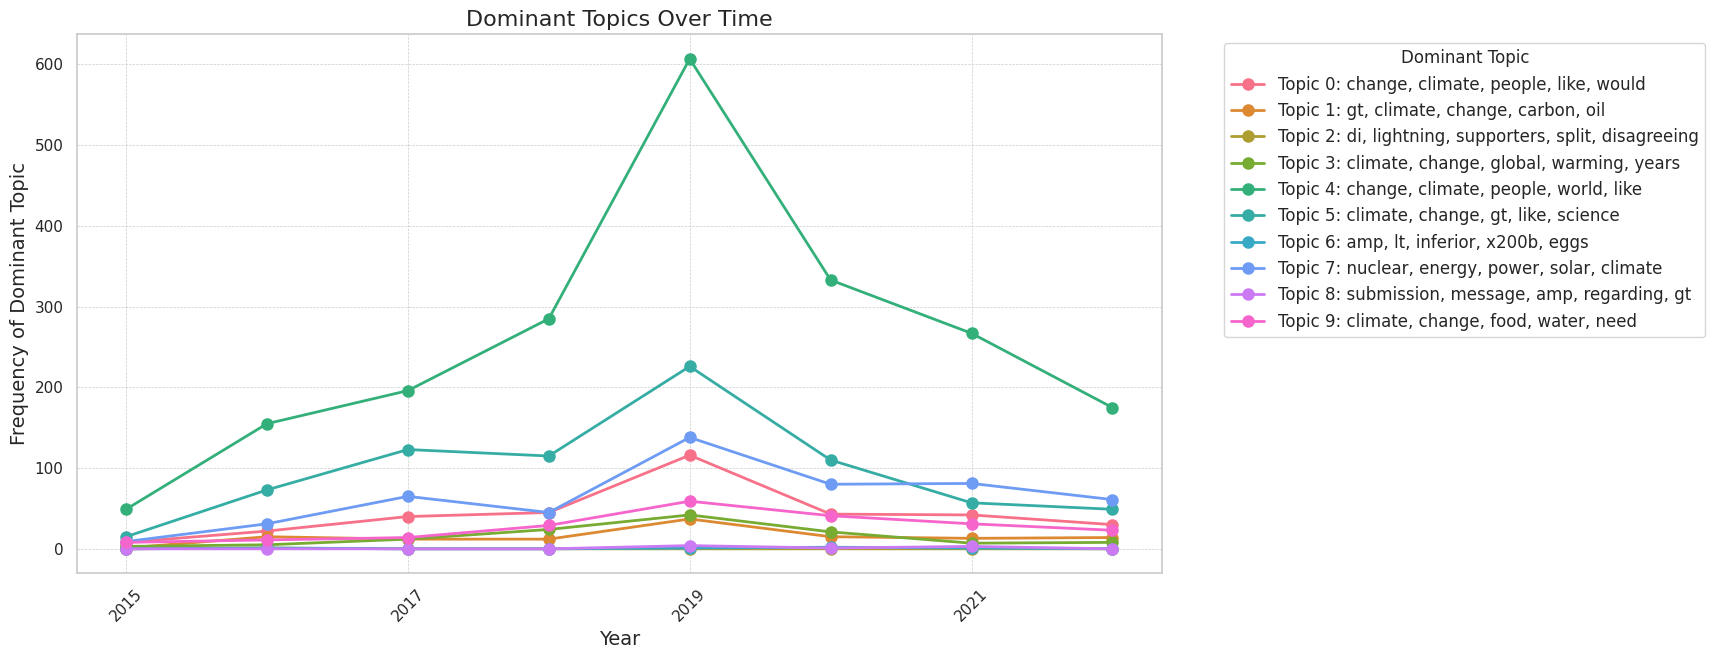

In [42]:
analyze_topics_over_time(df_futurology, 'body', 'date', num_topics=10, passes=15, topn_words=5)